In [9]:
import numpy as np
import matplotlib.pyplot as plt

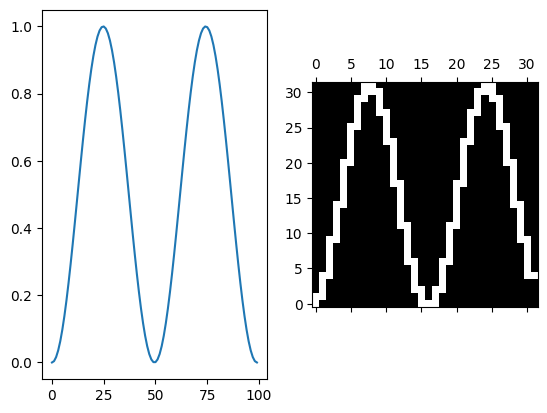

In [12]:
minmax = lambda x: (min(x), max(x))

def encode(series, n):
    plot = np.zeros((n,n))
    series = series[::len(series)//n][:n]
    series/=series.max()
    disc = (series*(n-1)).astype(int)
    for i in range(n):
        miny, maxy = minmax(disc[i:i+2])
        plot[miny:maxy+1,i]=1
    return plot

x = np.sin(np.linspace(0, 2*np.pi, 100))**2
ax1, ax2 = plt.subplot(121), plt.subplot(122)
ax1.plot(x)
ax2.matshow(encode(x, 32), origin="lower", cmap="gray")

In [7]:
import pandas as pd
prices = pd.read_csv("data/eurusd_minute.csv")['BidClose'].values
prices.shape

(5164235,)

/var/folders/2g/ynpc1dss2s5c7_ls09477clr0000gn/T/ipykernel_13428/1030032858.py:6: RuntimeWarning: invalid value encountered in divide
  series/=series.max()


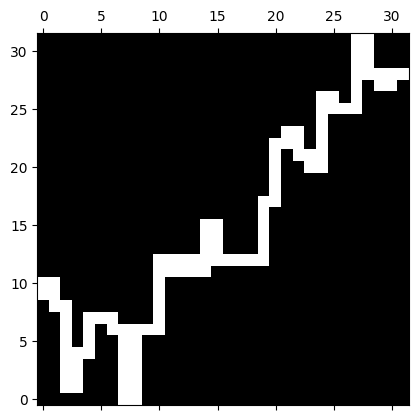

In [34]:
from torch.utils.data import Dataset

class PlotDataset(Dataset):
    def __init__(self, prices, n):
        values = np.array(prices)
        values = values[:len(values)//n*n]
        values = values.reshape(-1,n)
        values -= values.min(axis=1).reshape(-1,1)
        plots = np.zeros((len(prices)//n, n, n))
        for i in range(len(values)):
            plots[i]= encode(values[i], n)

        self.x = torch.from_numpy(plots).float()


    def __len__(self):
        return self.x.size(0) 

    def __getitem__(self, idx):
        out = self.x[idx]
        return out

dataset = PlotDataset(prices, 32)
plt.matshow(dataset[0], origin="lower", cmap="gray")

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [43]:
from src.models import Discriminator, Generator
from src.trainer import WGanGpTrainer
import torch.optim as optim
from torch.utils.data import DataLoader

d = Discriminator()
g = Generator()


trainer = WGanGpTrainer(
    generator=g,
    critic=d,
    gen_optimizer=optim.Adam(g.parameters(), lr=1e-4, betas=(0.0, 0.9)),
    critic_optimizer=optim.Adam(d.parameters(), lr=1e-4, betas=(0.0, 0.9)),
    latent_dimension=100,
    device=device,
    model_dir=None,
    write_dir="plot_experiment",
)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
trainer.train(train_loader, 100)

TypeError: Cannot handle this data type: (1, 1, 32), |u1